In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jangedoo/utkface-new

 99% 329M/331M [00:16<00:00, 21.5MB/s]
100% 331M/331M [00:16<00:00, 20.9MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

**Simple functional model with one input and two outputs**


In [3]:
from keras.models import Model

In [12]:
model=Model(inputs=x,outputs=[output1,output2])

In [13]:
from keras.layers import *

In [14]:
x=Input(shape=(3))

hidden1=Dense(12,activation='relu')(x)
hidden2=Dense(3,activation='relu')(hidden1)

output1=Dense(1,activation='linear')(hidden2)
output2=Dense(1,activation='sigmoid')(hidden2)

model.summary()

In [21]:
from keras.utils import plot_model

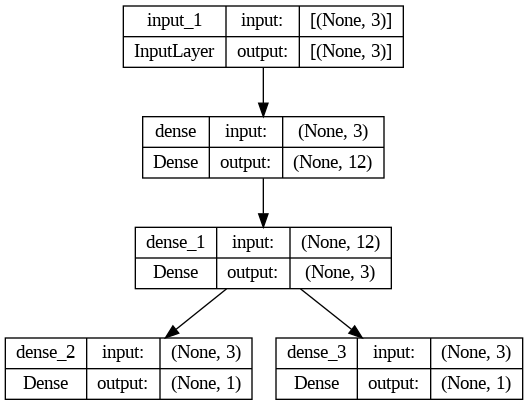

In [23]:
plot_model(model,show_shapes=True)

**Simple functional model with 1 input and 2 output shown above
===============================================================================================**





**Simple functional model with 2 inputs and 1 output created below**





In [32]:
from keras.layers import *

x1=Input(8)
x2=Input(8)

hidden11=Dense(64,activation='relu')(x1)
hidden12=Dense(64,activation='relu')(hidden11)

hidden21=Dense(64,activation='relu')(x2)
hidden22=Dense(64,activation='relu')(hidden21)

combined=concatenate([hidden12,hidden22])

hidden1=Dense(64,activation='relu')(combined)
hidden2=Dense(1,activation='linear')(hidden1)



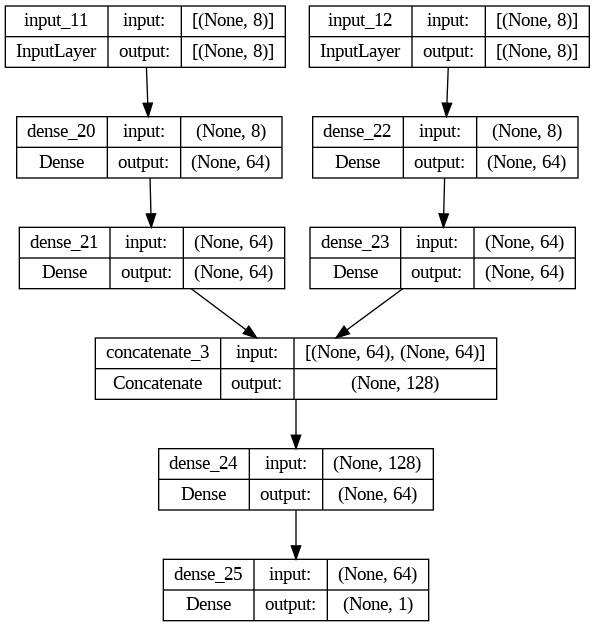

In [38]:
from keras.utils import plot_model
from keras.models import Model
model=Model(inputs=[x1,x2],outputs=hidden2)
plot_model(model,show_shapes=True)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## Project: Gender and Age classification from image

In [128]:
import os

In [129]:
path="/content/utkface_aligned_cropped/UTKFace"

In [132]:
age=[]
gender=[]
org_name=[]
for file in os.listdir(path):
  age.append(int((file.split("_"))[0]))
  gender.append(int((file.split("_"))[1]))
  org_name.append(file)


In [133]:
import pandas as pd

In [166]:
df=pd.DataFrame({"age":age,"gender":gender,"original_name":org_name})

In [167]:
df.shape

(23708, 3)

In [168]:
df.head(2)

,age,gender,original_name
0,26,1,26_1_3_20170104232413655.jpg.chip.jpg
1,2,0,2_0_4_20161221195155711.jpg.chip.jpg


In [171]:
train=df.sample(df.shape[0],random_state=0).iloc[:int(df.shape[0]*0.8),:]
test=df.sample(df.shape[0],random_state=0).iloc[int(df.shape[0]*0.8):,:]
print(df.shape)
print(train.shape)
print(test.shape)

(23708, 3)
(18966, 3)
(4742, 3)


In [172]:
train.head(2)

,age,gender,original_name
15426,14,1,14_1_2_20170104013310115.jpg.chip.jpg
14084,31,0,31_0_0_20170109134322184.jpg.chip.jpg


In [173]:
test.head(2)

,age,gender,original_name
21123,24,1,24_1_1_20170116224913775.jpg.chip.jpg
11608,26,1,26_1_3_20170119192110658.jpg.chip.jpg


In [174]:
  from keras.preprocessing.image import ImageDataGenerator


In [175]:
datagen=ImageDataGenerator(rescale=1./255)
""" another way is data augumentation where we can use ImageDataGenerator as below type and created artificial images
                ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)"""

In [176]:
train_generator=datagen.flow_from_dataframe(train,
                            directory=path,
                            x_col='original_name',
                            y_col=["age","gender"],
                            target_size=(200,200),
                            class_mode='multi_output')
test_generator=datagen.flow_from_dataframe(test,
                            directory=path,
                            x_col='original_name',
                            y_col=["age","gender"],
                            target_size=(200,200),
                            class_mode='multi_output')

Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [177]:
from keras.applications.vgg16 import VGG16
model_vgg=VGG16(include_top=False,weights='imagenet',input_shape=(200,200,3))

In [178]:
model_vgg.trainable=False

In [179]:
from keras.models import Model
from keras.layers import *

In [180]:
hidden1=model_vgg.layers[-1].output
hidden2=Flatten()(hidden1)

# Left for Age prediction
left1=Dense(128,activation='relu')(hidden2)
left2=Dense(1,activation='linear',name="age")(left1)

#Right for gender prediction
right1=Dense(128,activation='relu')(hidden2)
right2=Dense(1,activation='sigmoid',name="gender")(right1)

model=Model(inputs=model_vgg.input,outputs=[left2,right2])


In [181]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 200, 200, 64)         1792      ['input_17[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 200, 200, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)         0         ['block1_conv2[0][0]']        
                                                                                           

In [184]:
model.compile(optimizer='adam',loss={"age":"mae","gender":"binary_crossentropy"},metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [185]:
model.fit(train_generator,batch_size=32,epochs=10,validation_data=test_generator)

Epoch 1/10
593/593 [==============================] - 100s 147ms/step - loss: 50.0399 - age_loss: 9.3952 - gender_loss: 0.4106 - age_mae: 9.3952 - gender_accuracy: 0.8157 - val_loss: 37.6633 - val_age_loss: 7.7913 - val_gender_loss: 0.3017 - val_age_mae: 7.7913 - val_gender_accuracy: 0.8720
Epoch 2/10
593/593 [==============================] - 82s 138ms/step - loss: 35.8597 - age_loss: 7.5611 - gender_loss: 0.2858 - age_mae: 7.5611 - gender_accuracy: 0.8788 - val_loss: 42.0358 - val_age_loss: 8.6158 - val_gender_loss: 0.3376 - val_age_mae: 8.6158 - val_gender_accuracy: 0.8420
Epoch 3/10
593/593 [==============================] - 83s 140ms/step - loss: 32.0091 - age_loss: 6.9449 - gender_loss: 0.2532 - age_mae: 6.9449 - gender_accuracy: 0.8931 - val_loss: 37.0503 - val_age_loss: 7.1572 - val_gender_loss: 0.3020 - val_age_mae: 7.1572 - val_gender_accuracy: 0.8697
Epoch 4/10
593/593 [==============================] - 83s 141ms/step - loss: 29.5466 - age_loss: 6.5401 - gender_loss: 0.2324 

In [198]:
from keras.utils import load_img,img_to_array
import numpy as np
image=load_img(path+"/21_1_4_20170117193754349.jpg.chip.jpg")
image_arr=img_to_array(image)
input_arr=np.array([image_arr])/255

In [199]:
model.predict(input_arr)


1/1 [==============================] - 0s 29ms/step


[array([[22.294533]], dtype=float32), array([[0.9945235]], dtype=float32)]

In [193]:
test.head()

,age,gender,original_name
21123,24,1,24_1_1_20170116224913775.jpg.chip.jpg
11608,26,1,26_1_3_20170119192110658.jpg.chip.jpg
13412,53,0,53_0_0_20170111171747419.jpg.chip.jpg
19215,21,1,21_1_4_20170117193754349.jpg.chip.jpg
6495,53,1,53_1_0_20170110122130739.jpg.chip.jpg


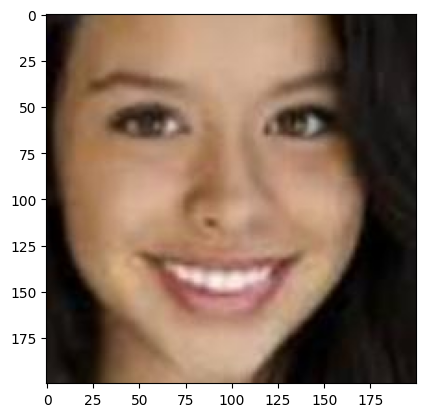

In [205]:
import matplotlib.pyplot as plt
plt.imshow(input_arr[0])

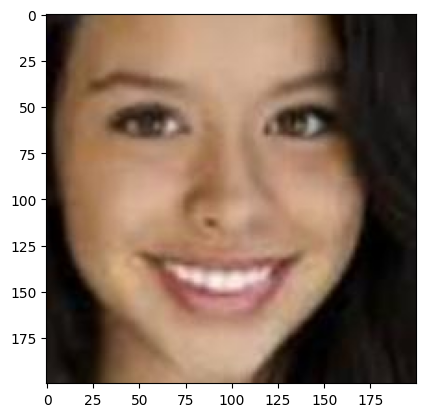

In [212]:
plt.imshow(image_arr/255)

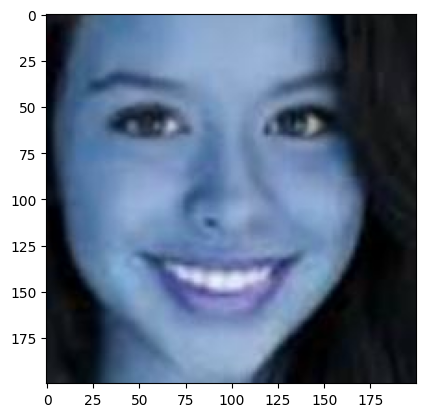

In [210]:
import cv2
test_img = cv2.imread(path+"/21_1_4_20170117193754349.jpg.chip.jpg")
plt.imshow(test_img)

In [237]:
xx="/content/keval.JPG"

In [246]:
xx="/content/Manbir1.jpeg"

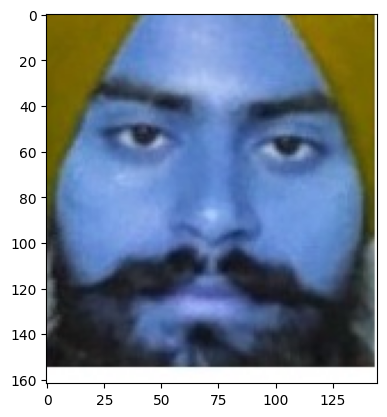

In [247]:
test_img = cv2.imread(xx)
plt.imshow(test_img)

In [248]:
test_img = cv2.resize(test_img,(200,200))
test_input = test_img.reshape((1,200,200,3))

In [249]:
image=load_img(xx)
image_arr=img_to_array(image)
input_arr=np.array([image_arr])/255

In [250]:
model.predict(test_input/255)

1/1 [==============================] - 0s 25ms/step


[array([[23.650522]], dtype=float32), array([[0.64341134]], dtype=float32)]

In [1]:
load_img(xx)

NameError: ignored